<a target="_blank" href="https://colab.research.google.com/github/kircherlab/MPRAlib/blob/master/examples/mpralib.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip --quiet install "MPRAlib==0.6.0"

# Loading Data and Understanding the MPRAlib data structure

Here we will load a barcode count file (output of [MPRAsnakeflow](https://github.com/kircherlab/MPRAsnakeflow)) into MPRAlib, more precise into an `MPRAData` data object in `mpralib.mpradata`. MPRAlib will generate an [AnnData](https://anndata.readthedocs.io) object out of it, which is acessable via `MRAData.data`:

<img src="https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg" alt="AnnData" width="480 "/>

## Core data

We defined two objects inhereted from `MPRAdata`:
- `MPRABarcodeData` for DNA and RNA counts per barcode
- `MPRAOligoData` for RNA and DNA counts aggregated per oligo

`MPRABarcodeData` can be generated from `MPRABarcodeData` but not vice versa. So we start with the `MPRABarcodeData` object:

### `MPRABarcodeData`

- `var`: barcodes
- `obs`: replicates

Oligo names are also stored in `var` like `MPRABarcodeData.data.var["oligo"]` and can also be accessed via `MPRABarcodeData.oligos`. Further DNA and RNA counts are stored in `layers` like `MPRABarcodeData.data.layers["dna"]` and `layers["rna"]`. This are the raw counts and those layers are never been modified. You can also access this data via `MPRABarcodeData.raw_rna_counts` and `MPRABarcodeData.raw_dna_counts`.

Metadata is stored in the `MPRABarcodeData.data.uns` dictionary.

#### Extended count data

There are some further layers that are dynamically updated via the library. This are:

1. Normalization layers in `MPRABarcodeData.data.layers["dna_normalized"]` and `MPRABarcodeData.data.layers["rna_normalized"]`. Usually we have to normalize the data to account for different sequencing depths. This is done by dividing the raw counts by the sum of the counts all counts per replicate and scale them (usually `1e6` like counts per million). We use a pseudo count of `1` to avoid division by zero. So barcodes are allowed to be not observed in either RNA or DNA. When both counts are zero the library will take this barcodes as not observed and will not use it for counting/normalization etc. The pseudocount can be modified via `MPRABarcodeData.PSEUDOCOUNT` e.g. avoiding it via `MPRABarcodeData.PSEUDOCOUNT = 0`.
2. Sampling layers in `MPRABarcodeData.data.layers["dna_sampling"]` and `MPRABarcodeData.data.layers["rna_sampling"]`. This is only an edge case when you want to downsample your counts.

The library usually generates the layers and takes care of them. E.g. when barcode filtering is applied, the normalization layers are updated accordingly.

MPRAlib provides some getters (in python properties) to access the data intuitively. E.g. `MPRABarcodeData.raw_dna_counts` will return the raw DNA counts. `MPRABarcodeData.raw_rna_counts` for RNA accordingly. If you use the property `MPRABarcodeData.rna_counts` or `MPRABarcodeData.dna_counts` it will return the latest counts. That can be the raw counts (if nothing was done), filtered counts when where some barcode counts are set to zero according to the barcode filter mask (see below), sampled or sampled and filtered counts. If you want to get norlazied counts use `MPRABarcodeData.normalized_rna_counts` or `MPRABarcodeData.normalized_dna_counts`. It returns the layer `"rna_normalized"` or `"dna_normalized"` which is a normalization of `MPRABarcodeData.rna_counts` or `MPRABarcodeData.dna_counts`.

#### Barcode filtering

Barcode filters are (or in AnnData filter for `var`) stored in a n_barcodes x n_replicates matrix within the AnnData object `MPRABarcodeData.data.varm["var_filter"]`. You can set any new filter using the setter `MPRABarcodeData.var_filter = new_filter`. The filter is a boolean matrix with `True` for barcodes that should be removed and `False` for barcodes that should be kept. This setter magically also updates the normalized counts for you.

There are pre implemented methods to filter barcodes, like detecting outliers. We will cover this part later.

### Grouping Data by Oligo - The `MPRAOligoData` object

Usually when we work with MPRA data we are not interested by the barcode count itself but an aggregated count version per oligo. This is done by grouping the data by oligo and writing a new MPRAlib object with a new AnnData object, called `MPRAOligoData` and `MPRAOligoData.data` accordingly. `MPRAOligoData` also inherits from `MPRAData` so has very similar functionality than `MPRABarcodeData`. It is a new AnnData object because the data structure is slightly different. The `var` are now the oligos and the `obs` remain the replicates. The layers `"dna"`, `"rna"`, `"dna_normalized"`, and  `"rna_normalized"` exist also for the grouped data but are now aggregated per oligo. 

When generating a `MPRAOligoData` from an `MPRABarcodeData` usually the filtered counts or sampled counts are used for aggregation (if applicable). Also you can define a barcode threshold to filter out oligos that have not enough barcodes. This threshold can be set by `MPRAdata.barcode_threshold = 10` for example. The default is 1 (no oligo is removed). Barcode thereshold is only applied when running correlations on the `MPRAOligoData` object or saving outputs. Otherwise you will see all counts from all oligos.

For this purpose we have one additional layers: `MPRAOligoData.data.layers["barcode_counts"]` counts the number of barcodes per oligo that was used for the aggregation (or simple property `MPRAOligoData.barcode_counts`). The layer is also available in MPRABarcode data and shows the same value for each barcode within the same oligo.

Maybe the most interesting layer is the one for activity (whch also exists in the barcode object but there this can be very sparse data): `MPRAOligoData.data.layers["activity"]` stores the log2 rna/dna ratio and can also be accessed via `MPRAOligoData.activities`.

## Example

Let's start with loading a barcode count file from [MPRAsnakeflow](https://github.com/kircherlab/MPRAsnakeflow):

In [2]:
# Loading the MPRAlib library
from mpralib.mpradata import MPRABarcodeData
# Loading other libraries
import pandas as pd
import numpy as np

# Load the data
mpra_barcode_data = MPRABarcodeData.from_file("../resources/barcode_counts.tsv.gz")

# Getting counts, no filtering/sampling done, so raw counts
print("DNA counts")
display(pd.DataFrame(mpra_barcode_data.dna_counts[:,0:5], index=mpra_barcode_data.obs_names, columns=mpra_barcode_data.var_names[0:5]))
print("RNA counts")
display(pd.DataFrame(mpra_barcode_data.rna_counts[:,0:5], index=mpra_barcode_data.obs_names, columns=mpra_barcode_data.var_names[0:5]))


DNA counts


barcode,CTAGGTAAGGCATAG,GCCTAATACTTTTTA,CAATGCCACAGAGAA,TACCCTCAAGTAAAC,ATGGTACTTAGGAGT
1,3,3,2,9,2
2,1,4,0,9,5
3,0,5,0,17,3


RNA counts


barcode,CTAGGTAAGGCATAG,GCCTAATACTTTTTA,CAATGCCACAGAGAA,TACCCTCAAGTAAAC,ATGGTACTTAGGAGT
1,4,3,2,3,12
2,2,7,0,16,6
3,0,3,0,27,10


### Correlation

We can correlate replicates based on DNA/RNA counts or activity. We are able to do this on a barcode level. But usually this generates very very low correlations:

In [3]:
from mpralib.mpradata import Modality
print("Pairwise Pearson correlation activity")
print(pd.DataFrame(mpra_barcode_data.correlation(), index=mpra_barcode_data.obs_names, columns=mpra_barcode_data.obs_names).round(3))
print("Pairwise Pearson correlation normalized DNA")
print(pd.DataFrame(mpra_barcode_data.correlation(count_type=Modality.DNA_NORMALIZED), index=mpra_barcode_data.obs_names, columns=mpra_barcode_data.obs_names).round(3))
print("Pairwise Pearson correlation normalized RNA")
print(pd.DataFrame(mpra_barcode_data.correlation(count_type=Modality.RNA_NORMALIZED), index=mpra_barcode_data.obs_names, columns=mpra_barcode_data.obs_names).round(3))

Pairwise Pearson correlation activity
       1      2      3
1  1.000  0.462  0.460
2  0.462  1.000  0.478
3  0.460  0.478  1.000
Pairwise Pearson correlation normalized DNA
       1      2      3
1  1.000  0.843  0.832
2  0.843  1.000  0.834
3  0.832  0.834  1.000
Pairwise Pearson correlation normalized RNA
       1      2      3
1  1.000  0.906  0.901
2  0.906  1.000  0.917
3  0.901  0.917  1.000


So let's do this for aggregated data (per Oligo not per barcode):

In [4]:
mpra_oligo_data = mpra_barcode_data.oligo_data

print("Pairwise Pearson correlation")
print(pd.DataFrame(mpra_oligo_data.correlation(), index=mpra_oligo_data.obs_names, columns=mpra_oligo_data.obs_names).round(3))
print("Parwise Spearman correlation")
print(pd.DataFrame(mpra_oligo_data.correlation(method="spearman"), index=mpra_oligo_data.obs_names, columns=mpra_oligo_data.obs_names).round(3))


# Setting a different barcode threshold 1, 10, 50 and getting the average across replicates
for threshold in [1, 10, 50]:
    mpra_oligo_data.barcode_threshold = threshold
    print(f"Mean Pearson correlation activity, BC threshold {mpra_oligo_data.barcode_threshold}: {mpra_oligo_data.correlation().flatten()[[1,2,5]].mean().round(3)}")
    
    print(f"Mean Pearson correlation RNA counts (normalized), BC threshold {mpra_oligo_data.barcode_threshold}: {np.mean(np.triu(mpra_oligo_data.correlation(count_type=Modality.RNA_NORMALIZED))).round(3)}")
    
    print(f"Mean Pearson correlation DNA counts (normalized), BC threshold {mpra_oligo_data.barcode_threshold}: {np.mean(np.triu(mpra_oligo_data.correlation(count_type=Modality.DNA_NORMALIZED))).round(3)}")

    print("")

Pairwise Pearson correlation
       1      2      3
1  1.000  0.578  0.002
2  0.578  1.000 -0.000
3  0.002 -0.000  1.000
Parwise Spearman correlation
       1      2      3
1  1.000  0.927  0.923
2  0.927  1.000  0.947
3  0.923  0.947  1.000
Mean Pearson correlation activity, BC threshold 1: 0.967
Mean Pearson correlation RNA counts (normalized), BC threshold 1: 0.662
Mean Pearson correlation DNA counts (normalized), BC threshold 1: 0.64

Mean Pearson correlation activity, BC threshold 10: 0.979
Mean Pearson correlation RNA counts (normalized), BC threshold 10: 0.664
Mean Pearson correlation DNA counts (normalized), BC threshold 10: 0.648

Mean Pearson correlation activity, BC threshold 50: 0.981
Mean Pearson correlation RNA counts (normalized), BC threshold 50: 0.664
Mean Pearson correlation DNA counts (normalized), BC threshold 50: 0.647



Using a higher threshold will also reduce our oligos available per replicate:

In [5]:
for threshold in [1, 10, 50]:
    mpra_oligo_data.barcode_threshold = threshold
    print(f"Number of oligos per individual replicate, using BC threshold {mpra_oligo_data.barcode_threshold}")
    print(np.sum(mpra_oligo_data.barcode_counts >= mpra_oligo_data.barcode_threshold,axis=1))


Number of oligos per individual replicate, using BC threshold 1
[7436 7437 7439]
Number of oligos per individual replicate, using BC threshold 10
[7288 7288 7287]
Number of oligos per individual replicate, using BC threshold 50
[7123 7132 7122]


We can also plot the correlation. Let's do it for barcode_threshold 50:

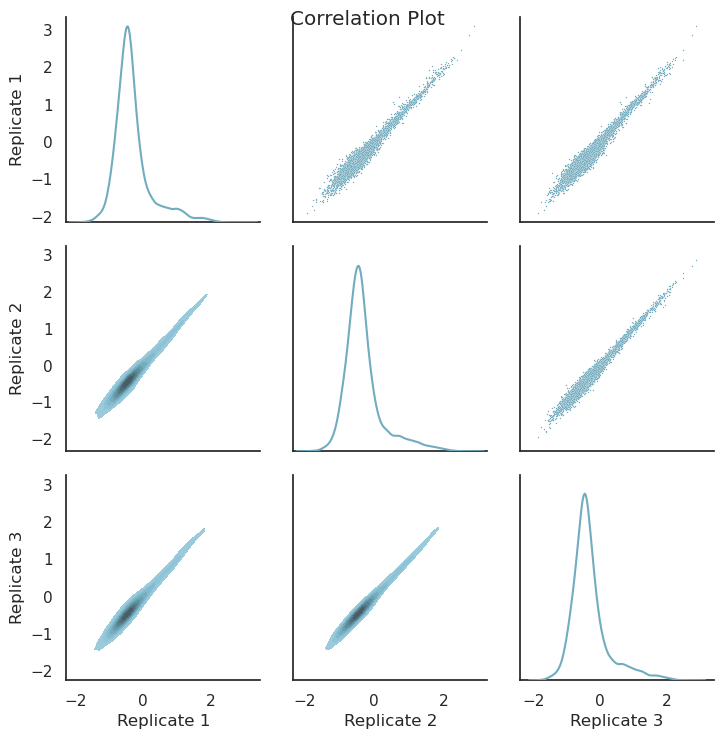

In [6]:
from mpralib.utils.plot import correlation
mpra_oligo_data.barcode_threshold = 50
correlation(mpra_oligo_data, Modality.ACTIVITY)

We have other usefull plots. E.g. We ant to see if we basically have activity in the data. So that we see on different DNA levels different RNA activities. So we plot now normalized DNA vs normalized RNA (mediana across replicates)

/home/mschubach/miniforge3/envs/jupyter/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mschubach/miniforge3/envs/jupyter/lib/python3.12/site-packages/mpralib/utils/plot.py:63: RuntimeWarning: divide by zero encountered in log10
  df = pd.DataFrame({"DNA [log10]": np.log10(median_dna), "RNA [log10]": np.log10(median_rna)})


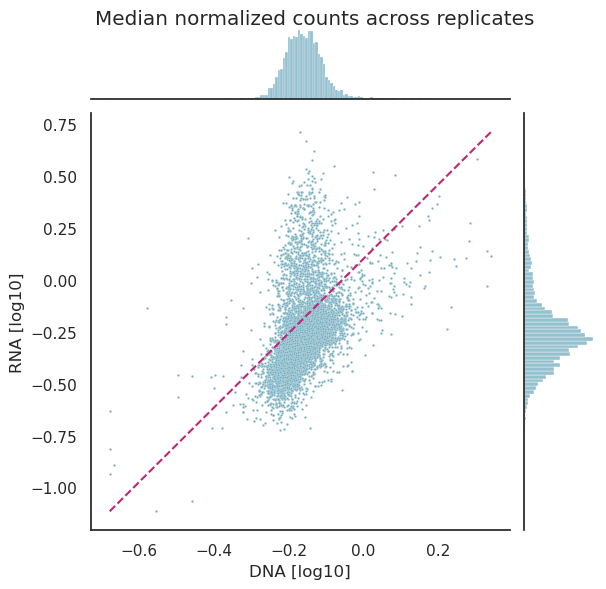

In [7]:
from mpralib.utils.plot import dna_vs_rna,barcodes_per_oligo
mpra_oligo_data.barcode_threshold = 1
dna_vs_rna(mpra_oligo_data)

Looks very good. The dots follow nearly a vertical line. When they would follow the dashed line we basically have no different activity in our data. So this is a good sign.

Also would be great to know how many barcodes per oligo we have:

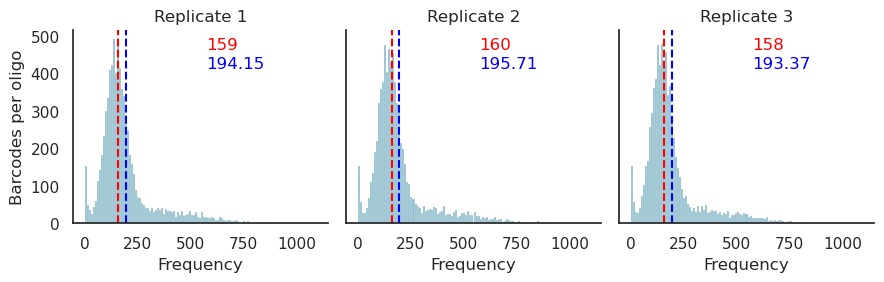

In [8]:
barcodes_per_oligo(mpra_oligo_data)

## Barcode filtering and outlier detection

There is some pre-build function to remove barcodes from experiments. This is done via the function `MPRAData.apply_barcode_filter()`. This function has pre-build filters like setting a minimum or maximum threshold for counts. E.g. you want to remove very very high barcode counts or you 'trust' only barcode counts with 3 RNA counts to remove noisy data. The functin can also randomly remove barcodes if you want to downsample your data on barcodes (Which correspons to removing barcodes from your assignment, theerfor ehaving a lower quality/lower depth assignment file).

But it can also detect outlier barcodes. E.g. if you want to remove barcodes that do not follow the distribution per oligo. This is usually done per repliacte.

Now we try to remove barcodes that are outliers within the RNA counts using the zscore:

In [9]:
from mpralib.mpradata import BarcodeFilter

# using standard number of barcodes per oligo
mpra_barcode_data.barcode_threshold = 10

# Resetting the barcode filter
mpra_barcode_data.barcode_filter = None
mpra_oligo_data = mpra_barcode_data.oligo_data
print(f"Mean Pearson correlation before BC filter, BC threshold {mpra_oligo_data.barcode_threshold}")
print(np.mean(np.triu(mpra_oligo_data.correlation())).round(3))
print(f"Number of oligs")
print(np.sum(mpra_oligo_data.barcode_counts >= mpra_oligo_data.barcode_threshold,axis=1))

# Apply filter
mpra_barcode_data.apply_barcode_filter(BarcodeFilter.RNA_ZSCORE, {"times_zscore": 3})

mpra_oligo_data = mpra_barcode_data.oligo_data
print(f"Mean Pearson correlation after BC filter, BC threshold {mpra_oligo_data.barcode_threshold}")
print(np.mean(np.triu(mpra_oligo_data.correlation())).round(3))
print(f"Number of oligs")
print(np.sum(mpra_oligo_data.barcode_counts >= mpra_oligo_data.barcode_threshold,axis=1))

Mean Pearson correlation before BC filter, BC threshold 10
0.66
Number of oligs
[7288 7288 7287]
Mean Pearson correlation after BC filter, BC threshold 10
0.66
Number of oligs
[7288 7288 7287]


You see we keeping number of oligos the same but our Person correlaton was (slightly) increased. Now we want to see the barcodes that were removed. We can access them using the  `MPRAData.barcode_filter` matrix on the `MPRAData.var` (our barcodes) object. We also compute all barcodes that are consistently renoved across repliactes.

In [10]:
common_barcodes = None
for i, replicate in enumerate(mpra_barcode_data.var_filter):
    print(f"Number of removed barcodes in replicate {i}: {len(mpra_barcode_data.data.var_names[mpra_barcode_data.var_filter.iloc[:,i]])}")
    if common_barcodes is None:
        common_barcodes = mpra_barcode_data.data.var_names[mpra_barcode_data.var_filter.iloc[:,i]]
    else:
        common_barcodes = common_barcodes.intersection(mpra_barcode_data.data.var_names[mpra_barcode_data.var_filter.iloc[:,i]])
print(f"Number of common barcodes: {len(common_barcodes)}")
print(f"Common barcodes: {common_barcodes}")

Number of removed barcodes in replicate 0: 27071
Number of removed barcodes in replicate 1: 27121
Number of removed barcodes in replicate 2: 26857
Number of common barcodes: 9999
Common barcodes: Index(['CAATAAAAAGAGATG', 'CTCGCTTGCTGCAAG', 'CGGCGGCCAACGCAC',
       'TCCCCAGCGGATGCT', 'CCGTGCCAGTTATTG', 'CCCCCGTGCCCACCG',
       'AAGATCCTGCTGTCG', 'TCCACACCTACCTCA', 'CACCTCAACACGCAC',
       'CTAGAGACCGAAGGA',
       ...
       'CCCGCCGCCCCCCGG', 'ACGCGCGATACGGAG', 'TTAAGCTCAACTTAC',
       'GTGCATCGTCCTCGC', 'CGTAACGCCCGCCAG', 'TCTTTAACCTGATCT',
       'AAATAAAGAGGTAAC', 'CCACTAGAACGCTGA', 'AGGACAACAATTTGA',
       'CACATATAACTACGA'],
      dtype='object', name='barcode', length=9999)


Let's see if we achieve something else when allowing only a higher number of DNA and RNA counts:

In [11]:
mpra_barcode_data.var_filter = None

mpra_oligo_data = mpra_barcode_data.oligo_data
print(f"Mean Pearson correlation before BC filter, BC threshold {mpra_oligo_data.barcode_threshold}")
print(np.mean(np.triu(mpra_oligo_data.correlation())).round(3))
print(f"Number of oligs")
print(np.sum(mpra_oligo_data.barcode_counts >= mpra_oligo_data.barcode_threshold,axis=1))

# Apply filter
mpra_barcode_data.apply_barcode_filter(BarcodeFilter.MIN_COUNT, {"dna_min_count": 2, "rna_min_count": 4})

mpra_oligo_data = mpra_barcode_data.oligo_data
print(f"Mean Pearson correlation before BC filter, BC threshold {mpra_oligo_data.barcode_threshold}")
print(np.mean(np.triu(mpra_oligo_data.correlation())).round(3))
print(f"Number of oligs")
print(np.sum(mpra_oligo_data.barcode_counts >= mpra_oligo_data.barcode_threshold,axis=1))

Mean Pearson correlation before BC filter, BC threshold 10
0.66
Number of oligs
[7288 7288 7287]
Mean Pearson correlation before BC filter, BC threshold 10
0.659
Number of oligs
[7276 7277 7276]


This reduces our correlation and also the number of oligos. that fullfills the BC threshold 10 criteria.

## Saving activity files.

Finally we want to safe our oligo activities. We have a pre-build function for that.

In [12]:
from mpralib.utils.io import export_activity_file, export_barcode_file
export_activity_file(mpra_oligo_data, "activity.tsv.gz")

df = pd.read_csv("activity.tsv.gz", sep='\t', nrows = 20)
display(df)

,replicate,oligo_name,dna_counts,rna_counts,dna_normalized,rna_normalized,log2FoldChange,n_bc
0,1,Negative_100_(chr20:23361299-23361499),1806,2963,0.9689,0.8788,-0.1408,161
1,1,Negative_101_(chr20:45230745-45230945),1190,2667,0.7169,0.8614,0.2648,148
2,1,Negative_102_(chr20:51863129-51863329),3964,4875,0.9289,0.6420,-0.5330,370
3,1,Negative_103_(chr20:5611877-5612077),1081,1618,0.8058,0.6663,-0.2743,118
4,1,Negative_104_(chr20:9067910-9068110),1514,1832,0.8392,0.5704,-0.5570,158
5,1,Negative_105_(chr21:43076112-43076312),1280,1309,0.8483,0.4944,-0.7789,132
6,1,Negative_106_(chr22:20981319-20981519),1031,1147,0.8363,0.5263,-0.6683,108
7,1,Negative_107_(chr22:21044386-21044586),1498,1434,0.9861,0.5410,-0.8660,131
8,1,Negative_108_(chr22:22898023-22898223),1566,2117,0.8555,0.6445,-0.4085,160
9,1,Negative_109_(chr22:23856687-23856887),1031,1285,0.8093,0.5649,-0.5187,112


So every oligo per replicate is written into one row with its counts, normalized counts, log2 fold change and the number of supporting barcodes. 

Remark: We just load the first 20 oligos.

We can also write out the results in a barcode format

In [13]:
export_barcode_file(mpra_barcode_data, "barcodes.tsv.gz")

df = pd.read_csv("barcodes.tsv.gz", sep='\t', nrows=20)
display(df)

,barcode,oligo_name,dna_count_1,rna_count_1,dna_count_2,rna_count_2,dna_count_3,rna_count_3
0,CTAGGTAAGGCATAG,Negative_100_(chr20:23361299-23361499),3.0,4.0,NaN,NaN,NaN,NaN
1,GCCTAATACTTTTTA,Negative_100_(chr20:23361299-23361499),NaN,NaN,4.0,7.0,NaN,NaN
2,CAATGCCACAGAGAA,Negative_100_(chr20:23361299-23361499),NaN,NaN,NaN,NaN,NaN,NaN
3,TACCCTCAAGTAAAC,Negative_100_(chr20:23361299-23361499),NaN,NaN,9.0,16.0,17.0,27.0
4,ATGGTACTTAGGAGT,Negative_100_(chr20:23361299-23361499),2.0,12.0,5.0,6.0,3.0,10.0
5,GCGGCCGCTCCCCCG,Negative_100_(chr20:23361299-23361499),14.0,24.0,15.0,40.0,15.0,27.0
6,AGATGGAAATGTAAA,Negative_100_(chr20:23361299-23361499),8.0,5.0,7.0,15.0,NaN,NaN
7,AGACTGAGAGTGTGA,Negative_100_(chr20:23361299-23361499),40.0,41.0,28.0,54.0,25.0,48.0
8,ATCACCACTTTTTGA,Negative_100_(chr20:23361299-23361499),NaN,NaN,NaN,NaN,NaN,NaN
9,ACTTCACATTCTTTA,Negative_100_(chr20:23361299-23361499),NaN,NaN,NaN,NaN,NaN,NaN


This dumped the whole DNA and rna counts into a file. Same format as we loaded the data. BUT now with the filtereing applied. So we see a little bit more missing values.

Remark: We just load the first 20 oligos.